In [1]:
import torch
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
# hyperparameters
BATCH_SIZE = 512
ENC_LAYERS = [784, 512, 256, 128]
DEC_LAYERS = [128, 256, 512, 784]
LATENT_SIZE = 100
NUM_LABELS = 10
LEARNING_RATE = 1e-4
EPOCHS = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = FashionMNIST('data', train=True, transform=transform, download=True)
testset = FashionMNIST('data', train=False, transform=transform, download=True)
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=True)

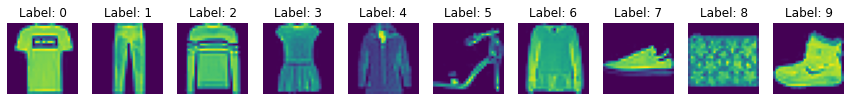

In [4]:
label_plotted = []
fig, ax = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(15, 10))
for ft, lb in trainset:
    if lb not in label_plotted:
        ax[lb].imshow(ft.squeeze())
        ax[lb].axis('off')
        ax[lb].set_title(f'Label: {lb}')
        label_plotted.append(lb)

    if len(label_plotted) >= 10:
        break
plt.show()

In [5]:
def one_hot(labels, num_labels):
    if labels.dim() == 1:
        labels = labels.unsqueeze(1)
    onehot = torch.zeros(labels.shape[0], num_labels).to(labels.device)
    onehot.scatter_(1, labels, 1)

    return onehot

In [6]:
# build the network
class Encoder(nn.Module):
    def __init__(self, latent_size, layer_sizes, num_labels):
        super(Encoder, self).__init__()

        # properties
        self.latent_size = latent_size
        self.num_labels = num_labels
        self.layer_sizes = layer_sizes

        # input layer
        self.layer_sizes[0] += num_labels

        # encoder layers
        self.encoder = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.encoder.add_module(name=f'Linear-{i}', module=nn.Linear(in_size, out_size))
            self.encoder.add_module(name=f'ReLU-{i}', module=nn.ReLU())
        
        # reparametrization layer
        self.mu = nn.Linear(layer_sizes[-1], latent_size)
        self.logvar = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x, labels):
        
        # one hot encoding
        labels = one_hot(labels, self.num_labels)
        # add labels to feature
        x = torch.cat((x, labels), dim=-1)
        # forward pass
        x = self.encoder(x)
        # for reparametrization
        mu = self.mu(x)
        logvar = self.logvar(x)

        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, latent_size, layer_sizes, num_labels):
        super(Decoder, self).__init__()

        # properties
        self.latent_size = latent_size
        self.layer_sizes = layer_sizes
        self.num_labels = num_labels

        # input size
        self.input_size = latent_size + num_labels
        self.layer_sizes = [self.input_size] + self.layer_sizes

        # decoder layers
        self.decoder = nn.Sequential()
        for i, (in_size, out_size) in enumerate(zip(self.layer_sizes[:-1], self.layer_sizes[1:])):
            self.decoder.add_module(name=f'Linear-{i}', module=nn.Linear(in_size, out_size))
            if i + 1 < len(layer_sizes):
                self.decoder.add_module(name=f'ReLU-{i}', module=nn.ReLU())
            else:
                # add sigmoid activation
                self.decoder.add_module(name='Sigmoid', module=nn.Sigmoid())

    def forward(self, z, labels):

        # one hot encoding
        labels = one_hot(labels, self.num_labels)
        # add label to latent space
        z = torch.cat((z, labels), dim=-1)
        # forward pass
        x = self.decoder(z)
        
        return x


class CVAE(nn.Module):
    def __init__(self, latent_size, enc_sizes, dec_sizes, num_labels):
        super(CVAE, self).__init__()

        # properties
        self.latent_size = latent_size        
        self.num_labels = num_labels
        self.encoder_sizes = enc_sizes  # encoder layer sizes
        self.decoder_sizes = dec_sizes  # decoder layer sizes

        # layers
        self.encoder = Encoder(latent_size, enc_sizes, num_labels)
        self.decoder = Decoder(latent_size, dec_sizes, num_labels)        

    def forward(self, x, c):
        
        # reshape x from [BATCH_SIZE, 1, 28, 28] --> [BATCH_SIZE, 784]
        x = x.view(x.shape[0], -1)
        # input -> encoder
        mu, logvar = self.encoder(x, c)
        # latent space + reparameterization trick
        z = self.reparameterize(mu, logvar)
        # latent space -> decoder
        recon_x = self.decoder(z, c)

        return recon_x, mu, logvar, z
        
        
    def reparameterize(self, mu, logvar):
        
        # TODO: add explanation of reparameterization
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        return mu + eps * std

    def inference(self, z, c):

        return self.decoder(z, c)

In [7]:
# loss function
def loss_fn(recon_x, x, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)    
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """    
    # BCE = nn.BCELoss(reduction='sum')(recon_x, x.view(-1, 784))   # reconstructive loss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')   # reconstructive loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())   # KL Divergence loss

    return (BCE + KLD) / x.size(0)

In [8]:
# training properties
cvae = CVAE(LATENT_SIZE, ENC_LAYERS, DEC_LAYERS, NUM_LABELS)
cvae = cvae.to(DEVICE)

optim = Adam(cvae.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
history = {'train_loss': [],
           'val_loss': [],
           'epochs': EPOCHS}

In [9]:
# train loop
for e in tqdm(range(EPOCHS)):
    
    cvae.train()
    train_loss = 0
    
    for features, labels in trainloader:        

        # move to device
        features, labels = features.to(DEVICE), labels.to(DEVICE)
        # forward pass
        optim.zero_grad()
        recon_x, mu, logvar, z = cvae(features, labels)
        # loss
        loss = loss_fn(recon_x, features, mu, logvar)
        train_loss += loss.item()
        # backward
        loss.backward()
        optim.step()        

    # logging
    history['train_loss'].append(train_loss/len(trainloader))


    cvae.eval()
    val_loss = 0

    with torch.no_grad():
        for features, labels in testloader:
            
            # move to device
            features, labels = features.to(DEVICE), labels.to(DEVICE)
            # forward pass
            recon_x, mu, logvar, _ = cvae(features, labels)
            # loss
            loss = loss_fn(recon_x, features, mu, logvar)
            # logging
            val_loss += loss.item()

    # logging
    history['val_loss'].append(val_loss/len(testloader))

    if e+1 % 10 == 0:
        print(f'[{e+1}/{EPOCHS}] Train Loss: {train_loss/len(trainloader):.4f} | Val Loss: {val_loss/len(testloader):.4f}')

  0%|          | 0/50 [00:00<?, ?it/s]

[1/50] Train Loss: 444.5771 | Val Loss: 377.5019
[2/50] Train Loss: 366.4756 | Val Loss: 351.5889
[3/50] Train Loss: 321.5916 | Val Loss: 309.5106
[4/50] Train Loss: 304.6581 | Val Loss: 303.4655
[5/50] Train Loss: 300.1227 | Val Loss: 300.5403
[6/50] Train Loss: 296.6861 | Val Loss: 295.9411
[7/50] Train Loss: 293.3794 | Val Loss: 292.7951
[8/50] Train Loss: 290.5914 | Val Loss: 290.3306
[9/50] Train Loss: 287.4390 | Val Loss: 286.7961
[10/50] Train Loss: 283.6257 | Val Loss: 283.9423
[11/50] Train Loss: 280.6527 | Val Loss: 280.3107
[12/50] Train Loss: 277.7851 | Val Loss: 278.0824
[13/50] Train Loss: 275.1515 | Val Loss: 274.9851
[14/50] Train Loss: 272.6229 | Val Loss: 272.8679
[15/50] Train Loss: 270.2628 | Val Loss: 270.2786
[16/50] Train Loss: 268.3194 | Val Loss: 269.0639
[17/50] Train Loss: 266.6718 | Val Loss: 267.8261
[18/50] Train Loss: 265.3937 | Val Loss: 266.3315
[19/50] Train Loss: 264.1596 | Val Loss: 265.0034
[20/50] Train Loss: 263.2552 | Val Loss: 264.2713
[21/50] T

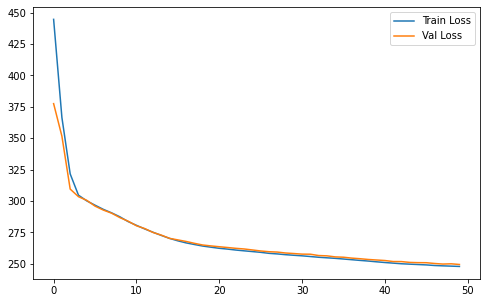

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [11]:
labels = torch.tensor([i for i in range(10) for _ in range(10)]).unsqueeze(1).to(DEVICE)
z = torch.randn(labels.shape[0], LATENT_SIZE).to(DEVICE)
recon_x = cvae.inference(z, labels).detach().cpu().numpy()

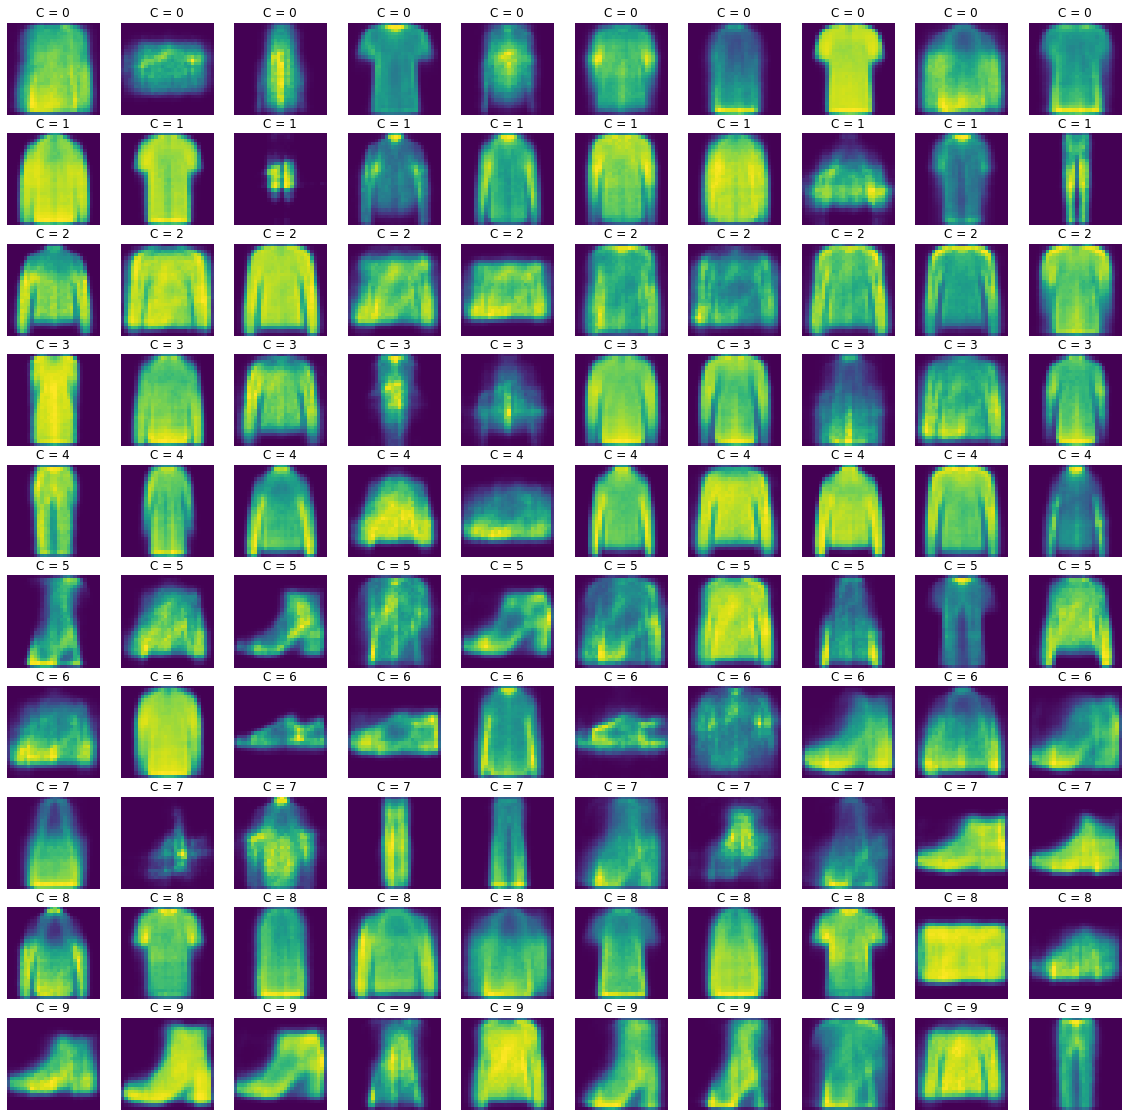

In [12]:
labels_ = labels.view(10, -1).cpu().numpy()
recon_x_ = recon_x.reshape(10, 10, 28, 28)
# prepare figure
fig, ax = plt.subplots(*labels_.shape, figsize=(20,20), sharex=True, sharey=True)
for lbl in labels_:
    for j, i in enumerate(lbl):
        ax[i, j].imshow(recon_x_[i][j])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'C = {i}')
        
plt.show()